In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 1. Loading data

Loading two datasets namely "yelp_business" and "yelp_review"

In [2]:
original_business_df = pd.read_csv("yelp_business.csv")

In [3]:
original_business_df.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [4]:
original_reviews_df = pd.read_csv("yelp_review.csv", nrows=1000000)

In [5]:
original_reviews_df.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


# 2. Data cleaning
To get the best results, we are cleaning up the `text` column of the reviews dataset to get rid of non-alphabetic characters.

In [6]:
# Filtering unused columns
business_columns_to_keep = ['business_id', 'name', 'city', 'state', 'latitude', 'longitude', 'review_count']
business_df = original_business_df[business_columns_to_keep]
business_df.head()

,business_id,name,city,state,latitude,longitude,review_count
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",Ahwatukee,AZ,33.330690,-111.978599,22
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",McMurray,PA,40.291685,-80.104900,11
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",Phoenix,AZ,33.524903,-112.115310,18
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",Tempe,AZ,33.383147,-111.964725,9
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",Cuyahoga Falls,OH,41.119535,-81.475690,116


In [7]:
# Filtering unused columns
reviews_columns_to_keep = ['review_id', 'user_id', 'business_id', 'stars', 'date', 'text']
reviews_df = original_reviews_df[reviews_columns_to_keep]
reviews_df.head()

,review_id,user_id,business_id,stars,date,text
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...


In [8]:
# Removing Null values
print(business_df.shape, reviews_df.shape)
business_df = business_df.dropna() # Drops all rows that contain null values
reviews_df = reviews_df.dropna()
print(business_df.shape, reviews_df.shape)

(174567, 7) (1000000, 6)
(174564, 7) (1000000, 6)


In [9]:
# Merging two datasets

business_reviews_df = pd.merge(business_df, reviews_df, on='business_id', how='inner')
business_reviews_df.shape

(999988, 12)

In [10]:
business_reviews_df.head()

,business_id,name,city,state,latitude,longitude,review_count,review_id,user_id,stars,date,text
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",Ahwatukee,AZ,33.33069,-111.978599,22,3_-fne2m2GvKESZRlULAiw,jTvKkNTat9QftSxL_FMcQw,5,2017-02-22,"They make a plan, for your mouth to get health..."
1,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",Ahwatukee,AZ,33.33069,-111.978599,22,5gJk64TDq5lqSuoNiaqjVQ,IG6XMgQyWF2_RW1nKEioxA,5,2015-01-20,I have extreme anxiety when it comes to the de...
2,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",Ahwatukee,AZ,33.33069,-111.978599,22,5570rwX_o30Z3NmKhou4CQ,2Rh41EBjWI137N2m5VHJJA,5,2013-06-06,I've only been here once but my husband has be...
3,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",Ahwatukee,AZ,33.33069,-111.978599,22,iRm438GDAajUiW2GoIAvtA,YcmNpPM0ag94g4T0zAtdcg,4,2016-05-07,Great experience with the hygenists and pediat...
4,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",Ahwatukee,AZ,33.33069,-111.978599,22,9lhJwhRwTsqqPyyoSjMuqw,XGL7VDkeUyM5nKQspJBTNw,5,2014-04-13,My husband and I went to this dentist as a rec...


In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text) 
    return text

business_reviews_df['cleaned_text'] = business_reviews_df['text'].apply(clean_text)

# 3. Overview of Data

In [12]:
business_reviews_df.describe()

,latitude,longitude,review_count,stars
count,999988.000000,999988.000000,999988.000000,999988.000000
mean,37.285967,-100.954109,352.215828,3.730457
std,4.307939,20.667366,738.228391,1.439177
min,-36.086009,-142.466650,3.000000,1.000000
25%,33.609078,-115.154332,33.000000,3.000000
50%,36.107183,-111.965225,108.000000,4.000000
75%,40.445146,-80.861432,328.000000,5.000000
max,89.999314,115.086769,7361.000000,5.000000


In [13]:
print('unique reviews in the dataset --->', business_reviews_df['review_id'].nunique())
print('unique users in the dataset --->', business_reviews_df['user_id'].nunique())
print('unique businesses in the dataset --->', business_reviews_df['business_id'].nunique())

unique reviews in the dataset ---> 999988
unique users in the dataset ---> 259417
unique businesses in the dataset ---> 136029


# 4. Data pre-processing
We are setting up the sentiment boundaries. Anything below 3 star is classified as negative and given value 0 and any reviews with 4 stars or more is classified as positive and given value 1. Anything in between is classified as None.

In summary:
- Stars >= 4: 1 - Positive review
- Starts <= 2: 0 - Negative review
- Else: None

Finally, all the reviews with above None values are removed as this is irrelevant in our further analysis.

In [14]:
business_reviews_df['sentiment'] = business_reviews_df['stars'].apply(lambda x: 0 if x <= 2 else (1 if x >= 4 else None))
business_reviews_df = business_reviews_df.dropna(subset=['sentiment'])

# 5. Model training
Now a regression model is trained on the above data. The data is vectorized with TF-IDF vectorized before it is fed to the model for training.

In [15]:
X = business_reviews_df['cleaned_text']
y = business_reviews_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000, random_state=111)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, random_state=111)

# 6. Model evaluation
Once the model is trained, we have to evaluate the performance. 

              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90     44748
         1.0       0.96      0.97      0.97    132440

    accuracy                           0.95    177188
   macro avg       0.94      0.93      0.93    177188
weighted avg       0.95      0.95      0.95    177188



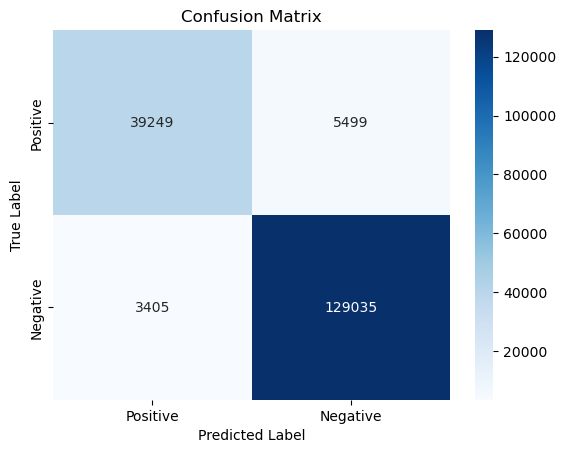

In [16]:
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The model manages to produce a good accuracy score of 95%

### Results
Now we have the predictions, we can have a quick look the most features 50 keywords in both positive and negative reviews.

Top 50 Positive Keywords:
[('heaven', 5.460191328660198), ('courteous', 5.464321974155173), ('reasonably', 5.466885298145271), ('comfortable', 5.697887221645295), ('yum', 5.759060941531236), ('tasty', 5.773673555716267), ('exceptional', 5.790993258035639), ('delish', 5.839751690055448), ('happy', 5.969201567168767), ('affordable', 5.976881994662416), ('bomb', 6.0113052116576835), ('solid', 6.041741594117374), ('helped', 6.094143388193723), ('fabulous', 6.254273443477772), ('gem', 6.335956497330142), ('satisfied', 6.352402480229768), ('easy', 6.422276329146937), ('beat', 6.544302989992371), ('phenomenal', 6.722341605238829), ('pleasantly', 6.741184170689051), ('perfection', 7.000186381178274), ('good', 7.070753973938703), ('friendly', 7.0772594584360755), ('knowledgeable', 7.088901068461931), ('professional', 7.30240851077095), ('notch', 7.381726958698028), ('reasonable', 7.4329796682431155), ('pleased', 7.481000734601213), ('glad', 7.507076958112704), ('yummy', 7.630342428033158), ('he

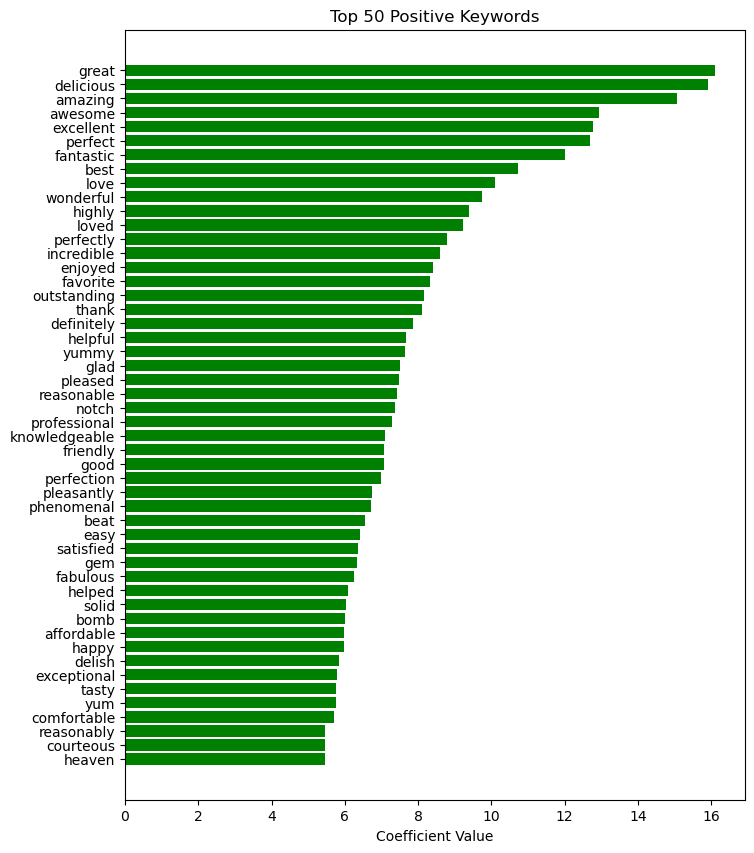

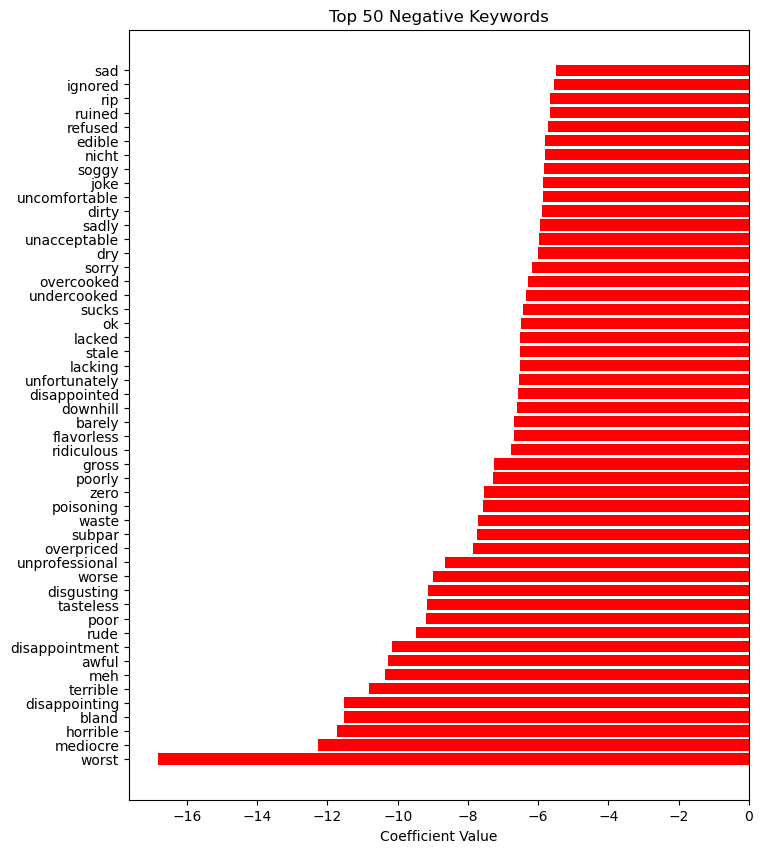

In [17]:
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
coefficients = model.coef_[0]

positive_indices = np.argsort(coefficients)[-50:]
negative_indices = np.argsort(coefficients)[:50] 

top_positive_keywords = feature_names[positive_indices]
top_negative_keywords = feature_names[negative_indices]

positive_scores = coefficients[positive_indices]
negative_scores = coefficients[negative_indices]

print("Top 50 Positive Keywords:")
print(list(zip(top_positive_keywords, positive_scores)))

print("\nTop 50 Negative Keywords:")
print(list(zip(top_negative_keywords, negative_scores)))

plt.figure(figsize=(8, 10))
plt.barh(top_positive_keywords, positive_scores, color='green')
plt.xlabel('Coefficient Value')
plt.title('Top 50 Positive Keywords')
plt.show()


plt.figure(figsize=(8, 10))
plt.barh(top_negative_keywords, negative_scores, color='red')
plt.xlabel('Coefficient Value')
plt.title('Top 50 Negative Keywords')
plt.show()


# 7. USECASE

Lets take Top Ten Best Reviewed Business in Toronto.

We list the Top Ten business in Toronto giving importance to the number of reviews and then to the number of stars obtained by the business.

In [18]:
# Filtering toronto city
toronto_business_reviews = original_business_df[original_business_df["city"] == "Toronto"]

# Sort by 'review_count' and 'stars' in descending order
toronto_business_reviews = toronto_business_reviews.sort_values(by=["review_count", "stars"], ascending=[False, False])

## Top 10 best review businesses

In [19]:
# Get the top 10 best review businesses
toronto_top_review_business = toronto_business_reviews.head(10)
toronto_top_review_business

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
107580,r_BrIgzYcwo1NAuG9dLbpg,"""Pai Northern Thai Kitchen""",Entertainment District,"""18 Duncan Street""",Toronto,ON,M5H 3G8,43.647866,-79.388642,4.5,1494,1,Food;Ethnic Food;Specialty Food;Restaurants;Thai
158973,aLcFhMe6DDJ430zelCpd2A,"""Khao San Road""",Entertainment District,"""11 Charlotte St""",Toronto,ON,M5V 2H5,43.646411,-79.393480,4.0,1270,1,Thai;Restaurants
9526,RtUvSWO_UZ8V3Wpj0n077w,"""KINKA IZAKAYA ORIGINAL""",Downtown Core,"""398 Church St""",Toronto,ON,M5B 2A2,43.660524,-79.378927,4.0,1184,1,Tapas Bars;Japanese;Nightlife;Tapas/Small Plat...
131553,N93EYZy9R0sdlEvubu94ig,"""Banh Mi Boys""",Queen Street West,"""392 Queen Street W""",Toronto,ON,M5V 2A9,43.648827,-79.396970,4.0,973,1,Vietnamese;Delicatessen;Asian Fusion;Restauran...
80828,iGEvDk6hsizigmXhDKs2Vg,"""Seven Lives Tacos Y Mariscos""",Kensington Market,"""69 Kensington Avenue""",Toronto,ON,M5T 2K2,43.654341,-79.400480,4.5,945,1,Mexican;Restaurants;Seafood
5191,RwRNR4z3kY-4OsFqigY5sw,"""Uncle Tetsu's Japanese Cheesecake""",Downtown Core,"""598 Bay Street""",Toronto,ON,M5G 1M5,43.655969,-79.384013,3.5,848,1,Food;Desserts;Bakeries;Japanese;Restaurants
49153,-av1lZI1JDY_RZN2eTMnWg,"""Salad King Restaurant""",Downtown Core,"""340 Yonge Street""",Toronto,ON,M5B 1R8,43.657648,-79.381728,3.5,808,1,Restaurants;Thai
110247,zgQHtqX0gqMw1nlBZl2VnQ,"""Momofuku Noodle Bar""",Financial District,"""190 University Avenue, Ground Floor""",Toronto,ON,M5H 0A3,43.649678,-79.386275,3.0,759,1,American (New);Ramen;Asian Fusion;Restaurants;...
68285,uAAWlLdsoUf872F1FKiX1A,"""Bang Bang Ice Cream and bakery""",Ossington Strip,"""93a Ossington Avenue""",Toronto,ON,M6J 2Z2,43.646286,-79.419474,4.0,746,1,Food;Desserts;Ice Cream & Frozen Yogurt
36440,f5O7v_X_jCg2itqacRfxhg,"""Sansotei Ramen""",Downtown Core,"""179 Dundas Street W""",Toronto,ON,M5G 1Z8,43.655004,-79.386473,4.0,701,1,Ramen;Japanese;Restaurants;Noodles


## Top 10 poor review businesses

In [20]:
# Get the top 10 poor review businesses
toronto_poor_review_business = toronto_business_reviews[toronto_business_reviews['stars'] == 1]
toronto_poor_review_business = toronto_poor_review_business.sort_values(by=["review_count"], ascending=[False]).head(10)
toronto_poor_review_business

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
156361,Gglsm0mtG3PI8BzTvOm3zg,"""NU Car Rental""",Etobicoke,"""801 Dixon Road""",Toronto,ON,M9W 1J5,43.686875,-79.587150,1.0,27,1,Hotels & Travel;Car Rental
27373,bIioipKX2IiES22VDFsytQ,"""Deal Find""",NaN,"""250 Ferrand Drive""",Toronto,ON,M3C,43.719474,-79.331912,1.0,24,1,Shopping;Wholesale Stores
79380,LgrGYXtuwumUODemA66VGQ,"""Royal Taxi""",NaN,"""2075 Bayview Avenue""",Toronto,ON,M4N 3M5,43.721704,-79.376008,1.0,22,1,Hotels & Travel;Taxis;Transportation
84048,XuS_k7rrv8VTvu2defcPTQ,"""Trans Canada Car Rental""",Etobicoke,"""801 Dixon Road""",Toronto,ON,M9W 1J5,43.687863,-79.586362,1.0,22,1,Hotels & Travel;Car Rental
29127,-6c_bJblLXUwoWfmYLtH_w,"""Neo-Paws International""",Etobicoke,"""2131 Lake Shore Boulevard W""",Toronto,ON,M8V 0B3,43.626932,-79.478738,1.0,17,1,Pet Stores;Pets;Pet Services;Pet Groomers;Pet ...
15685,4YVCTg53T7xRkFF4yKVj6Q,"""One A Minute Car Wash""",NaN,"""822 Church St""",Toronto,ON,M4W 2M9,43.672087,-79.385849,1.0,15,1,Auto Detailing;Car Wash;Auto Repair;Automotive
53145,AyuE2AyyKSZj97SNLAHM9w,"""Sbarro""",Downtown Core,"""Toronto Eaton Center, 220 Yonge Street""",Toronto,ON,M5B 2H1,43.655442,-79.381671,1.0,15,1,Restaurants;Italian;Fast Food;Food Court;Pizza
21380,D42mATIRcXGytmwycgaXew,"""Stitch it Clothing Alterations""",Yorkville,"""55 Bloor Street West, Unit 3""",Toronto,ON,M4W 1A1,43.669921,-79.389119,1.0,14,1,Sewing & Alterations;Local Services
120666,v6n7iPus9739N0VHR_v2rQ,"""Stori Aperitivo Bar""",St. Lawrence,"""95 King Street E""",Toronto,ON,M5C 1G3,43.649807,-79.374792,1.0,12,1,Cocktail Bars;Bars;Dance Clubs;Restaurants;Ita...
52772,ZrL5p18qbu-Ep9zU4YoEtw,"""Wrap & Roll""",Downtown Core,"""519 Yonge Street""",Toronto,ON,M4Y 1Y3,43.663646,-79.384006,1.0,11,0,Restaurants;Mediterranean


# 8. Topic Modelling

Lets take the first "Pai Northern Thai Kitchen" in top best review business

In [21]:
# Deep learning
import tensorflow_hub as hub

# Hugging Face
from transformers import pipeline

# Scikit-learn
from sklearn.cluster import KMeans

# NLP
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

In [22]:
# Download some nltk required data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aakas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aakas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
# Universal sentence encoder (from Google)
USE_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Function to use USE encoder
def embed(input):
    return np.array(USE_encoder(input))

In [24]:
# Get sentiment model from hugging face platform

sentiment_model = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [25]:
def sentiment(input):
    result = sentiment_model(input[:512])
    sign = 1 if(result[0]['label']=="POSITIVE") else -1
    value = result[0]['score']
    return sign*value

In [26]:
pai_thai_reviews = business_reviews_df[business_reviews_df['business_id'] == 'r_BrIgzYcwo1NAuG9dLbpg']['text'].dropna().tolist()

In [27]:
class ReviewsTopicModel:

    STOPWORDS = stopwords.words('english') # stopwords from ntlk

    EMBEDDING_DIM = 512 # USE encoder

    # Constructor
    def __init__(self, reviews):
        self.X = self.clean(reviews)

    # Clean text method
    def clean(self, reviews):
        # Words to replace
        string_map = {'\r': '', '\n': '', '/': ' ', "'": "", '"': ''}
        reviews_cleaned = reviews[:]
        for i in range(len(reviews_cleaned)):
            for s in string_map:
                reviews_cleaned[i] = reviews_cleaned[i].replace(s, string_map[s]).lower() 
        # Transform the reviews into embeddings dataframe
        X = embed(reviews_cleaned)
        X = pd.DataFrame(X)
        X.index = reviews_cleaned
        return X

    # Method to determine number of topics (a.k.a kmeans cluster number)
    def elbow_plot(self):
        cluster_sizes = list(range(1, 81))
        cluster_scores = []
        for n in cluster_sizes:
            kmeans = KMeans(n_clusters=n)
            kmeans.fit(self.X)
            cluster_scores.append(kmeans.inertia_)
        plt.figure()
        plt.plot(cluster_sizes, cluster_scores)
        plt.show()

    # Method to extract topics from text data
    def create_topics(self, num_topics):
        # Cluster the reviews
        kmeans = KMeans(n_clusters=num_topics)
        kmeans.fit(self.X)

        # Create the final topics dataframe
        topics_df = self.X.copy()
        topics_df['topic'] = kmeans.labels_.copy()
        topics_df['topic'] = topics_df['topic'].astype(int)

        # Create summary keywords per topic
        topic_keywords = {}
        for topic in topics_df['topic'].unique():
            topic_reviews = topics_df.query("topic == {}".format(topic)).index.tolist()
            topic_centroid = kmeans.cluster_centers_[topic] # cluster center
            topic_keywords[topic] = self.get_closest_words(topic_reviews, topic_centroid)
        topics_df['topic_keywords'] = topics_df['topic'].map(topic_keywords)

        # Score the sentiment of each review
        topics_df['sentiment'] = [sentiment(r) for r in topics_df.index.values.tolist()]

        # Final result
        self.topics_keywords = topic_keywords
        self.topics_df = topics_df.copy()[['topic', 'topic_keywords', 'sentiment']]


    def get_closest_words(self, reviews, centroid):
        word_distances = {}
        for r in reviews:
            review_words = [w for w in word_tokenize(r) if(w not in self.STOPWORDS)]
            for w in review_words:
                word_embedding = embed([w]) # return 512 dimensional vector for the word 'w'
                # how similar is the word embedding to the topic's centroid (avg of the cluster sample's embeddings)
                word_distances[w] = self.cosine_similarity(word_embedding, centroid) # 1 it means match, closer to 0 means different
        # done collecting the distances of the words to the topic's center
        top_5_keywords = sorted([(word_distances[w], w) for w in word_distances])[-5:]
        return ",".join([x[1] for x in top_5_keywords])

    def cosine_similarity(self, x, y):
        # x,y are both the appropriate dimension
        x = x.reshape(self.EMBEDDING_DIM,)
        y = y.reshape(self.EMBEDDING_DIM,)
        # calculate cosine similarity
        dotproduct = x.dot(y)
        x_mag = x.dot(x)**0.5
        y_mag = y.dot(y)**0.5
        # returns closer to 1 if x and y are similar, closer to 0 if they are different
        return dotproduct/(x_mag * y_mag)

In [28]:
topic_model = ReviewsTopicModel(pai_thai_reviews)

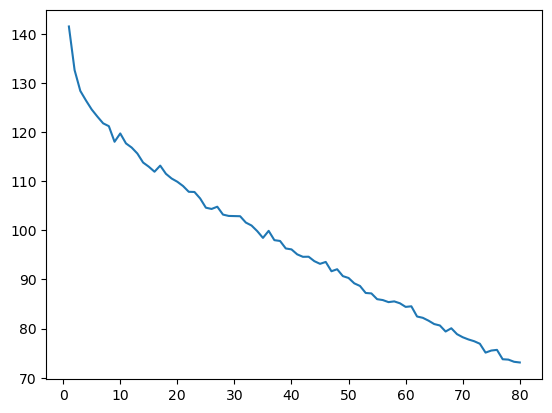

In [29]:
topic_model.elbow_plot() # going to use 50 clusters i.e. 50 topics

In [30]:
topic_model.create_topics(num_topics=50)

In [44]:
topic_model.topics_df.query("topic == 10")

,topic,topic_keywords,sentiment
love this place! great thai food and i believe the people who opened this place came from khao san road (another great thai place nearby) - so its obviously really good. great vibes and energy and good ambience. pretty decor and food is very well presented.,10,"food,ambience,curry,khao,thai",0.999880
"this review is intended for its new curry of the day in the extended space, not its main restaurant session. i have been to the restaurant for lunch dozens of times and also regularly take out its $10 curry of the day. recently they opened a new space for that during lunch time which is a good opportunity. after trying its green curry, which i am so familiar with, i was very disappointed with the poor food quality: pink coloured dark meat, watery source and 2\ 3 of usual volume. it is disappointing to see that pai cut corners to reduce cost when expanding. i do hope that they will improve the offering and give us the same quality soon.",10,"food,ambience,curry,khao,thai",-0.988619
"flavours are more to my liking, compared to khao san road.waiting lines *seem* shorter.",10,"food,ambience,curry,khao,thai",-0.998916
best thai place ever !! the green curry is to die for :),10,"food,ambience,curry,khao,thai",0.999686
"great food, amazing ambience. ordered pad thai and their green curry and it was delicious. definitely on par with khao san road, although pai has better presentation and way more seating.",10,"food,ambience,curry,khao,thai",0.999854
"really nice, fresh thai street food in a casual atmosphere. lots of fun!",10,"food,ambience,curry,khao,thai",0.999880


In [32]:
topic_model.topics_df.groupby(['topic', 'topic_keywords']).agg({'sentiment': 'mean'}).reset_index()\
    .sort_values(by='sentiment')

,topic,topic_keywords,sentiment
22,22,"asked,rude,dishes,gratuity,waiter",-0.999408
26,26,"management,stolen,camera,bag,cctv",-0.998695
0,0,"closing,restaurant,yelp,restaraunt,uber",-0.998460
28,28,"chang,drank,nikki,drinks,bae",-0.992813
15,15,"place,opening,dinner,afternoon,lunch",-0.938265
31,31,"dinning,shrimp,seated,portions,table",0.005252
23,23,"thailand,braised,menu,khao,thai",0.280627
10,10,"food,ambience,curry,khao,thai",0.335294
35,35,"noodles,wonton,thais,khao,thai",0.341509
48,48,"curries,satay,khao,thai,thai\",0.439405


# 9. Business Improvement Areas

A Business Improvement Area (BIA) is an association of commercial property owners and tenants within a defined area who work in partnership with the City to create thriving, competitive, and safe business areas that attract shoppers, diners, tourists, and new businesses. The BIA layer represents the active BIAs in the City of Toronto that has been enacted by Council. Each BIA has been defined by a by-law and is represented by a Board of Management. The layer is updated as BIAs are created, amended or deleted by Council.

## Comparing the performance of businesses inside BIAs with those outside to evaluate the impact of BIA initiatives.


In [33]:
from shapely.geometry import Point
import geopandas as gpd
import contextily as ctx

# Create GeoDataFrame for top review businesses
top_business_gdf = gpd.GeoDataFrame(
    toronto_top_review_business,
    geometry=[Point(xy) for xy in zip(toronto_top_review_business["longitude"], toronto_top_review_business["latitude"])],
    crs="EPSG:4326"  # WGS 84 projection
)

# Transform the business GeoDataFrame to match the polygon CRS (EPSG:3857)
top_business_gdf = top_business_gdf.to_crs(epsg=3857)

# ----

# Create GeoDataFrame for poor review business
poor_business_gdf = gpd.GeoDataFrame(
    toronto_poor_review_business,
    geometry=[Point(xy) for xy in zip(toronto_poor_review_business["longitude"], toronto_poor_review_business["latitude"])],
    crs="EPSG:4326"  # WGS 84 projection
)

# Transform the business GeoDataFrame to match the polygon CRS (EPSG:3857)
poor_business_gdf = poor_business_gdf.to_crs(epsg=3857)

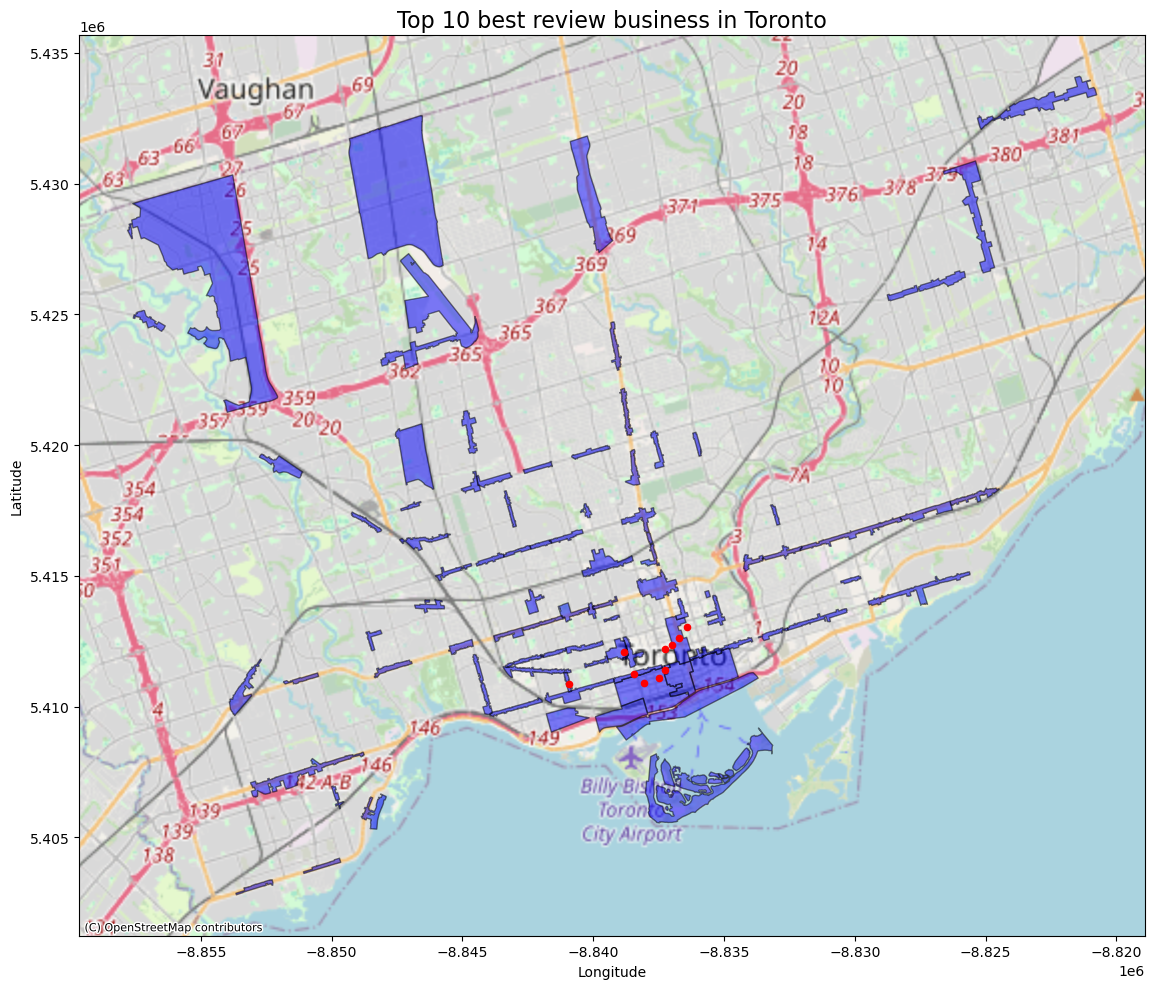

In [34]:
# Load the BIA polygon file
bia_data = gpd.read_file("Business Improvement Areas Data.geojson")

# Ensure the dataset is in a Web Mercator projection (EPSG:3857) for compatibility with basemaps
bia_data = bia_data.to_crs(epsg=3857)

# Plot the BIAs
fig, ax = plt.subplots(figsize=(12, 10))
bia_data.plot(ax=ax, color="blue", edgecolor="black", alpha=0.5)

top_business_gdf.plot(ax=ax, color="red", markersize=20, label="Businesses")


# Add a basemap (OpenStreetMap)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Customize plot
plt.title("Top 10 best review business in Toronto", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()

plt.show()

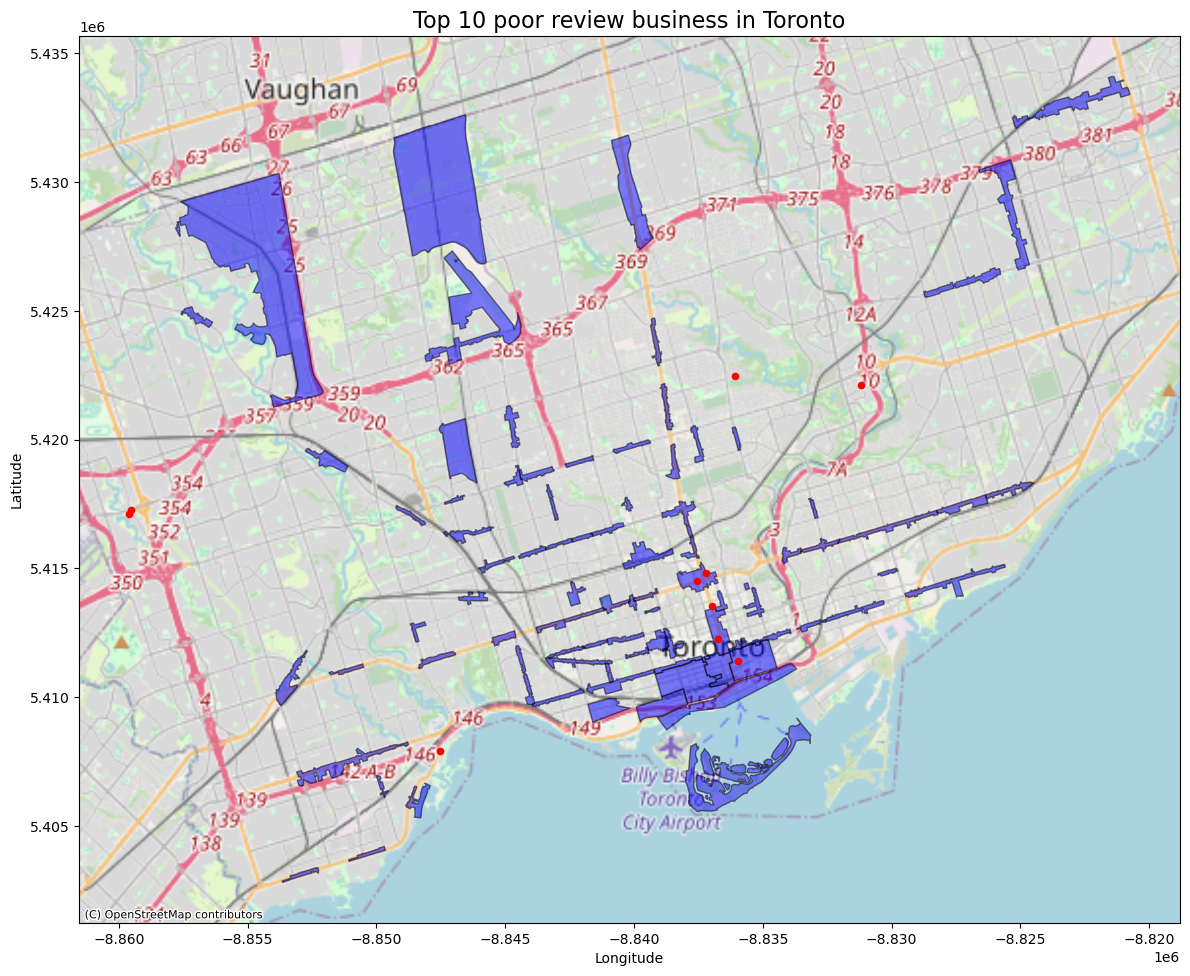

In [35]:
# Load the BIA polygon file
bia_data = gpd.read_file("Business Improvement Areas Data.geojson")

# Ensure the dataset is in a Web Mercator projection (EPSG:3857) for compatibility with basemaps
bia_data = bia_data.to_crs(epsg=3857)

# Plot the BIAs
fig, ax = plt.subplots(figsize=(12, 10))
bia_data.plot(ax=ax, color="blue", edgecolor="black", alpha=0.5)

poor_business_gdf.plot(ax=ax, color="red", markersize=20, label="Businesses")


# Add a basemap (OpenStreetMap)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Customize plot
plt.title("Top 10 poor review business in Toronto", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()

plt.show()